In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
import random
import corner
# Show plots inline, and load main getdist plot module and samples class
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
# use this *after* importing getdist if you want to use interactive plots
# %matplotlib notebook
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True
from scipy.stats import distributions
import scipy.optimize as opt
import emcee

GetDist Version: 1.1.2, Matplotlib version: 3.3.1


In [2]:
#introducción de los datos
#N es la cantidad de datos, NN el número de iteraciones para el programa caminante
#definición de av y bv para guardar los parámetros que cumplen la regla de selección
#av[0] y bv[0] son los parametros iniciales dados por uno, cv, y la creación de otras listas es para 
#parametros de otros modelos
#x1 y y1 son los datos 

NN=10000
dt=np.load('test_line.npy')
x1 = dt[0]
y1 = dt[1]
yerr=dt[2]
N=len(x1)
av=np.zeros(NN)
bv=np.zeros(NN)

In [3]:
def modelo(a, b):
        mod = a + (b*x1)
    #mod=a*(x**2)+b*x + c
    #mod=a*np.cos(b*x)+c
        return mod

In [4]:
#Con minimización Chi-square
def chisqfunc(x):
    a, b=x
    mu=modelo(a, b)
    chisq = np.sum(((y1 - mu)/yerr)**2)
    return chisq


x0 =np.array([0, 0])

result =  opt.minimize(chisqfunc, x0)

In [5]:
assert result.success==True
a, b=result.x
print(a, b)

206.78478516010392 19.338675053258736


In [6]:
#linear least square
A = np.vstack([dt[0], np.ones(len(dt[0]))]).T
b, a = np.linalg.lstsq(A, dt[1], rcond=None)[0]
print(a, b)

199.34272404405507 30.762307652444452


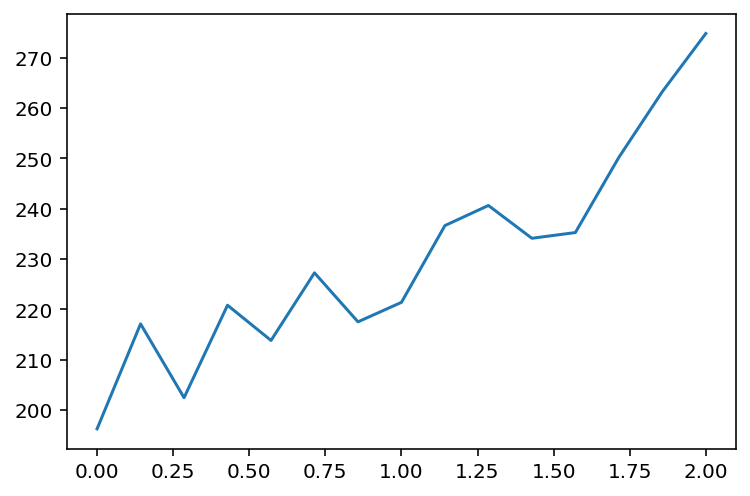

In [7]:
plt.plot(x1, y1)

In [8]:
def ls(a, b):
    mu = modelo(a, b)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y1 - mu) ** 2 / sigma2 + np.log(sigma2))

In [9]:
def prior(a, b):
    if -300<a<300 and -40<b<40:
        return 0
    return -np.inf

In [10]:
def MCM3(p1, p2):
    accepteda = []
    acceptedb = []
    rejecteda = [] 
    rejectedb = [] 
    av[0]=p1
    bv[0]=p2
    for k in range(NN-1):
        ak = np.random.normal(av[k], 4)
        bk = np.random.normal(bv[k], 1)
        posteriorold = ls(av[k], bv[k])+prior(av[k], bv[k])
        posteriornew = ls(ak, bk)+prior(ak, bk)
        ratio = posteriornew-posteriorold
        ran = math.log(random.uniform(0, 1))
    #print(ratio, ran)
        if ratio > 0:
            av[k+1] = ak
            bv[k+1] = bk
            accepteda.append(ak)
            acceptedb.append(bk)
        else:
            if ratio > ran:
                av[k+1] = ak
                bv[k+1] = bk
                accepteda.append(ak)
                acceptedb.append(bk)
            else:
                av[k+1] = np.copy(av[k])
                bv[k+1] = np.copy(bv[k])
                rejecteda.append(ak)
                rejectedb.append(bk)  
    ta=np.array(accepteda)
    tb=np.array(acceptedb)
    ra=np.array(rejecteda)
    rb=np.array(rejectedb)
    porc_a=(len(ta)/NN)
    porc_b=(len(tb)/NN)
    return av, bv, porc_a, porc_b
    #return plt.plot(av, bv, 'o'), print('el parámetro a es', av.mean()), print('el parámetro b es', bv.mean())

In [11]:
MCM3(200, 30)

(array([200.        , 200.        , 200.        , ..., 208.55545927,
        205.92714348, 210.65095667]),
 array([30.        , 30.        , 30.        , ..., 18.445026  ,
        18.12592117, 18.27886591]),
 0.3266,
 0.3266)

## Multiples caminadores

In [12]:
def multMCM(l, g):
    s1 = np.zeros((5, NN))
    s2 = np.zeros((5, NN))
    porca = np.zeros(5)
    porcb = np.zeros(5)
    for k in range(5):
        s1[k], s2[k], porca[k], porcb[k]=np.copy(MCM3(l[k], g[k]))
    return s1, s2, porca, porcb

In [13]:
g=np.array([29, 31, 28, 27, 29])
l=np.array([200, 201, 199, 204, 203])

In [14]:
s1, s2, pa, pb=multMCM(l, g)

C:\Users\ana__\miniconda3\envs\hola\lib\site-packages\numpy\lib\function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


## Análisis cuantitativo de cadenas

el porcentaje de aceptación para el parametro a y b respectivamente es:

In [15]:
pa.mean()

0.31895999999999997

In [16]:
pb.mean()

0.31895999999999997

La media y varianza de los 5 caminantes para el parametro a es 

In [17]:
s1.mean()

206.63761567357074

In [18]:
s1.var()

9.853206284793199

La media y varianza de los 5 caminantes para el parametro b es 

In [19]:
s2.mean()

19.457936433340095

In [20]:
s2.var()

5.788593539456221

In [21]:
#para el diagnóstico de Gelman-Rubin 
muv=np.zeros(2)
muv[0]=s1.mean()
muv[1]=s2.mean()

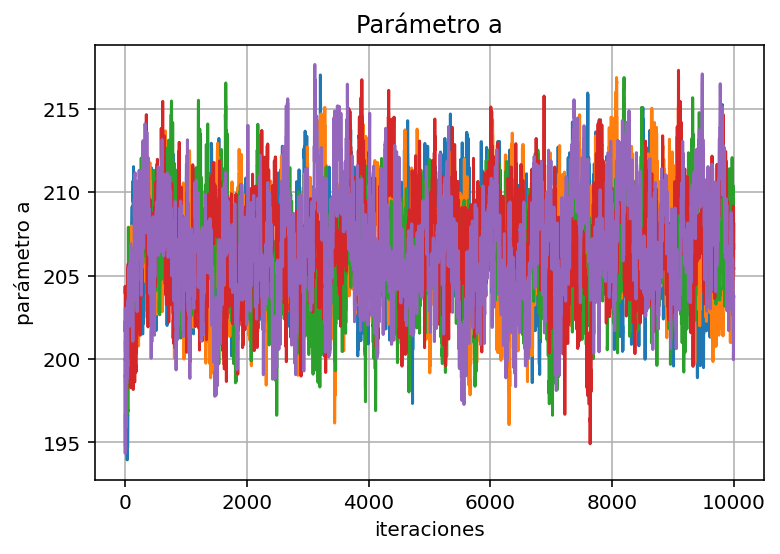

In [22]:
for i in range(5):
    plt.plot(np.arange(NN), s1[i])
plt.title(label='Parámetro a')
plt.xlabel('iteraciones')
plt.ylabel('parámetro a')
plt.grid()

Text(0, 0.5, 'parámetro b')

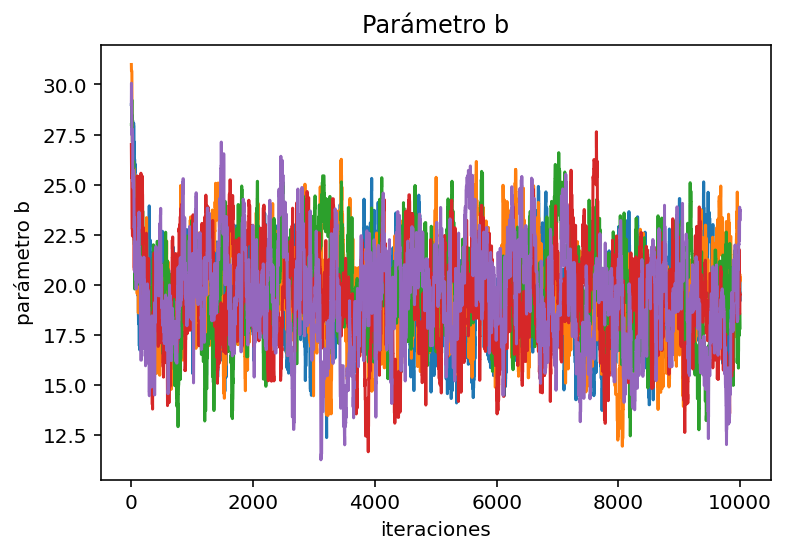

In [23]:
for i in range(5):
    plt.plot(np.arange(NN), s2[i])
plt.title(label='Parámetro b')
plt.xlabel('iteraciones')
plt.ylabel('parámetro b')

## Gráficas triangulares

### Definición de samples

In [24]:
samps=np.array([s1[0].T, s2[0].T]).T

In [26]:
samps2=np.array([s1[1].T, s2[1].T]).T

In [27]:
samps3=np.array([s1[2].T, s2[2].T]).T

In [28]:
samps4=np.array([s1[3].T, s2[3].T]).T

In [29]:
samps5=np.array([s1[4].T, s2[4].T]).T

In [31]:
ndim = 2
nsamp = NN

In [32]:
names = ['a0', 'b0']
labels =  ['a', 'b']
samples = MCSamples(samples=samps,names = names, labels = labels, label='first set')
samples2 = MCSamples(samples=samps2,names = names, labels = labels, label='Second set')
samples3 = MCSamples(samples=samps3,names = names, labels = labels, label='Second set')
samples4 = MCSamples(samples=samps4,names = names, labels = labels, label='Second set')
samples5 = MCSamples(samples=samps5,names = names, labels = labels, label='Second set')


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


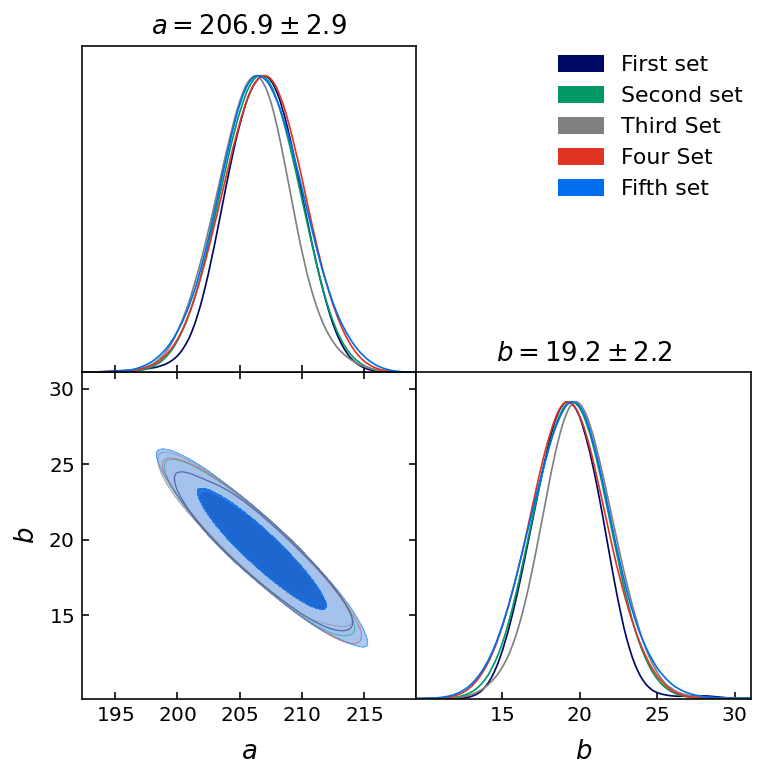

In [33]:
#### Triangle plot 
g = plots.get_subplot_plotter(width_inch=6)
g.settings.figure_legend_frame = False
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples, samples2, samples3, samples4, samples5], filled=True, legend_labels = ['First set', 'Second set', 'Third Set', 'Four Set', 'Fifth set'], legend_loc='upper right',
                title_limit=1)
#, param_limits={'a0': (196, 216), 'b0': (-0.5, -1.5)}
#  title limit same to 1 (for 1D plots) is 68% by default

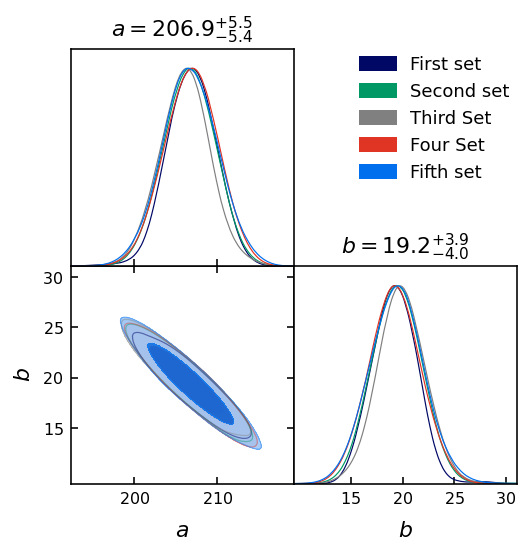

In [34]:
# Triangle plot 
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples, samples2, samples3, samples4, samples5], filled=True, legend_labels = ['First set', 'Second set', 'Third Set', 'Four Set', 'Fifth set'], legend_loc='upper right',
                title_limit=2)
#  title limit 2

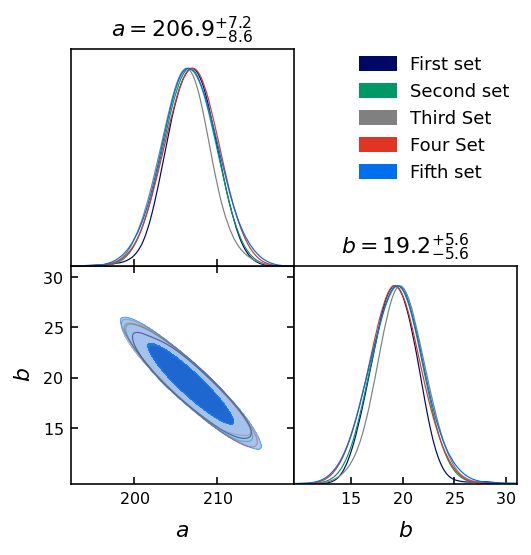

In [35]:
# Triangle plot 
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples, samples2, samples3, samples4, samples5], filled=True, legend_labels = ['First set', 'Second set', 'Third Set', 'Four Set', 'Fifth set'], legend_loc='upper right',
                title_limit=3)
#  title limit 3

Con respecto a los valores dados de los datos a=200, b=30. Para la minimización Chi-square a=206.78478516010392 b=19.338675053258736 y para el código MCMC para el primer sigma a=206.9$\pm$2.9, b=19.2$\pm$2.2

## Diagnóstico de Gelman-Rubin

$\hat{\mu} $ promedio de la muestra de los mn valores simulados de x, $\hat{\mu} $=$\bar{x}$

In [36]:
#uní los arreglos para los calculos
s=np.array([s1, s2])

In [37]:
sksq=np.zeros([2,5])
for k in range(2):
    for i in range(5):
        gr1=0
        for j in range(N):
            gr=(s[k][i][j]-s[k][i].mean())**2
            gr1=gr1+gr    
        sksq[k][i]=gr1/(N-1)

Calculo del promedio de las m varianzas, $s_{i}^{2}$, cada una dividida entre n-1 grados de libertad en la celda anterior

In [38]:
ssq=np.zeros(2)
for i in range(2):
    ssq[i]=(np.sum(sksq[i]))/5

Cálculo de B/n la varianza entre las m secuencias de media, $\bar{x_{i}}$, cada una en base de los n valores de x

In [39]:
sum=0
Bn=np.zeros(2)
for k in range(2):
    for i in range(5):
        dd=((s[k][i].mean()-muv[k])**2)
        sum=sum+dd
    Bn[k]=sum/4

Varianza $\hat{\sigma^{2}}$

In [40]:
varsq=np.zeros(2)
for k in range(2):
    varsq[k]=(N-1)*ssq[k]*(N**(-1))+Bn[k]

In [41]:
R=np.zeros(2)
for i in range(2):
    R[i]=math.sqrt(varsq[i]/ssq[i])

In [42]:
R

array([0.96676926, 0.96718696])

In [43]:
def posterior(theta, x, y, yerr):
    a, b=theta
    post=ls(a, b) +prior(a, b)
    return post

In [44]:
pos=np.array([200, 30])

In [47]:
pos = pos + 1e-4 * np.random.randn(5, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=(x1, y1, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2997.45it/s]


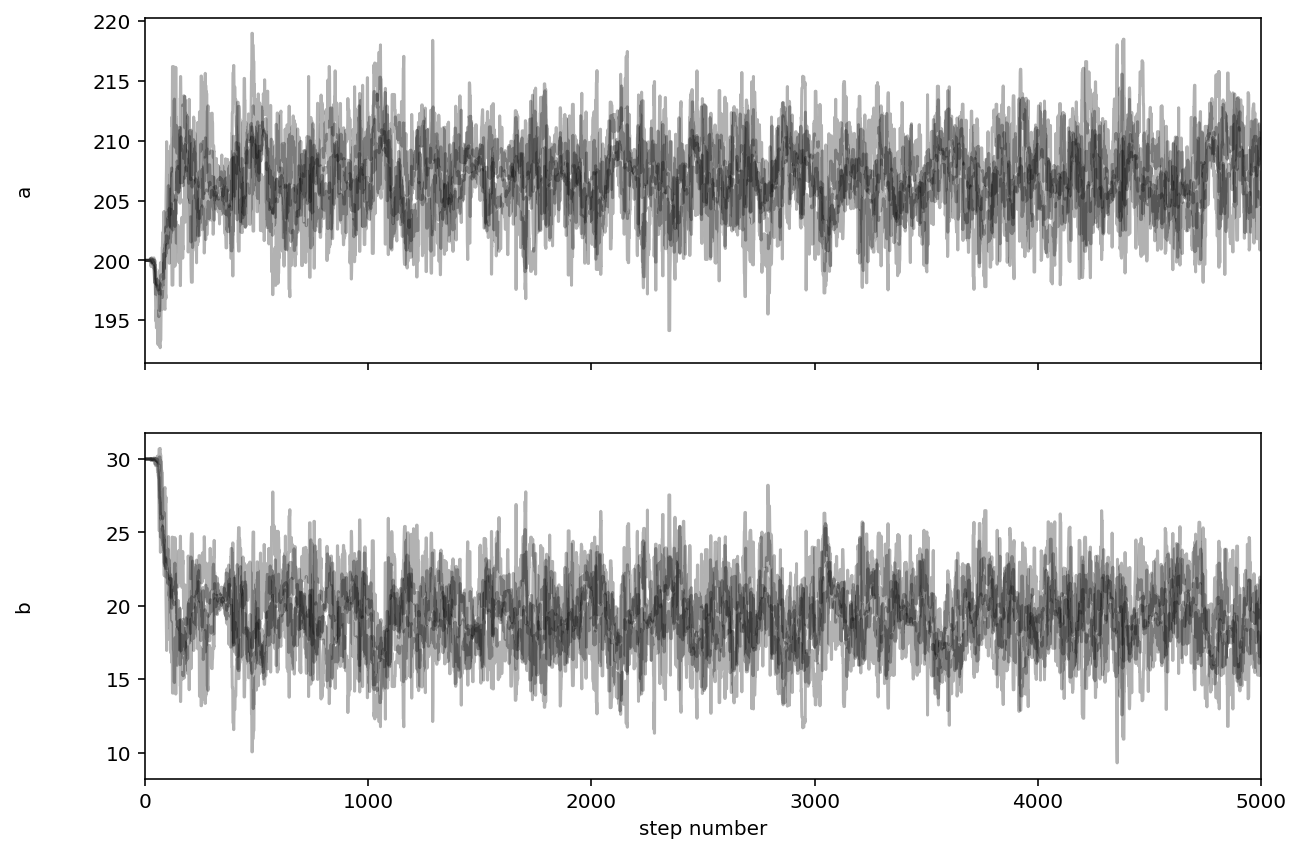

In [48]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [49]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

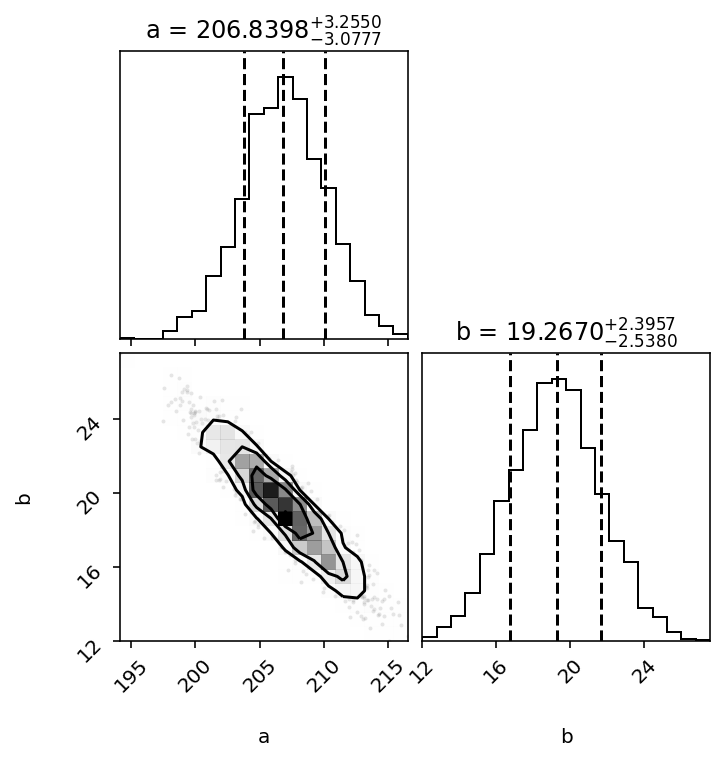

In [50]:
fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.50, 0.84], title_fmt='.4f', show_titles=True
);

Con respecto a los valores dados de los datos a=200, b=30. Para la minimización Chi-square a=206.78478516010392 b=19.338675053258736 y para el código MCMC para el primer sigma a=206.9$\pm$2.9, b=19.2$\pm$2.2
Para emcee tenemos a=206.8398$^{+3.2550}_{3.0777}$, b=19.26704$^{2.3957}_{-2.5380}$